In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ksowmya12","key":"08d6afd19c81d6ca2537815ae7f40be9"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
 #! kaggle datasets list
! kaggle competitions download -c 'datathonindoml-2022'
! mkdir datathon
! unzip datathonindoml-2022.zip -d datathon
print("done")

Streaming output truncated to the last 5000 lines.
  inflating: datathon/train/train/631.tif  
  inflating: datathon/train/train/6310.tif  
  inflating: datathon/train/train/6311.tif  
  inflating: datathon/train/train/6312.tif  
  inflating: datathon/train/train/6313.tif  
  inflating: datathon/train/train/6314.tif  
  inflating: datathon/train/train/6315.tif  
  inflating: datathon/train/train/6316.tif  
  inflating: datathon/train/train/6317.tif  
  inflating: datathon/train/train/6318.tif  
  inflating: datathon/train/train/6319.tif  
  inflating: datathon/train/train/632.tif  
  inflating: datathon/train/train/6320.tif  
  inflating: datathon/train/train/6321.tif  
  inflating: datathon/train/train/6322.tif  
  inflating: datathon/train/train/6323.tif  
  inflating: datathon/train/train/6324.tif  
  inflating: datathon/train/train/6325.tif  
  inflating: datathon/train/train/6326.tif  
  inflating: datathon/train/train/6327.tif  
  inflating: datathon/train/train/6328.tif  
  infl

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
labels_t = pd.read_csv("/content/datathon/train_labels.csv")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import cv2
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
from typing import Tuple

def resize_with_pad(image: np.array,
                    new_shape: Tuple[int, int],
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [ ]:
train_dir= "/content/datathon/train/train/"
X_tr = []
Y_tr = []

for name in labels_t['id'].values:
    temp = cv2.imread(train_dir + str(name)+".tif")
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2YUV)
    temp[:,:,0] = cv2.equalizeHist(temp[:,:,0])
    temp = cv2.cvtColor(temp, cv2.COLOR_YUV2BGR)
    temp = resize_with_pad(temp, (256, 256))
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
    temp = np.expand_dims(temp, axis=2)
    X_tr.append(temp)

X_tr = np.array(X_tr)
X_tr = X_tr.astype('float32')

In [ ]:
X_tr/=255
X_tr.shape

(16000, 256, 256, 1)

In [ ]:
y_train = labels_t['label']
y_train=np.array(y_train)
y_train.shape

(16000,)

In [ ]:
from keras.layers import LeakyReLU
from keras.regularizers import l2
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(256,256,1),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding = 'same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    #Dropout(0.2),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding = 'same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    MaxPool2D(pool_size=(2, 2), strides=1, padding="same"),
    BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding = 'same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding = 'same',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    Flatten(),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    #BatchNormalization(),
    Dense(16, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0

In [ ]:
! mkdir model_checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = '/content/model_checkpoints/weights.best.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

In [ ]:
history = model.fit(X_tr,y_train,
              batch_size= 32,
              epochs=50,
              validation_split=0.2,
              callbacks=[early_stop,checkpoint,reduce_lr],
              shuffle=True,
              verbose=1)

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 3.5724 - accuracy: 0.2930
Epoch 1: val_accuracy improved from -inf to 0.31750, saving model to /content/model_checkpoints/weights.best.hdf5
400/400 [==============================] - 76s 157ms/step - loss: 3.5724 - accuracy: 0.2930 - val_loss: 2.8870 - val_accuracy: 0.3175 - lr: 1.0000e-04
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 2.1321 - accuracy: 0.4881
Epoch 2: val_accuracy improved from 0.31750 to 0.49812, saving model to /content/model_checkpoints/weights.best.hdf5
400/400 [==============================] - 64s 159ms/step - loss: 2.1321 - accuracy: 0.4881 - val_loss: 2.0596 - val_accuracy: 0.4981 - lr: 1.0000e-04
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 1.7330 - accuracy: 0.5758
Epoch 3: val_accuracy improved from 0.49812 to 0.54781, saving model to /content/model_checkpoints/weights.best.hdf5
400/400 [==============================] - 62s 155ms/step - lo

In [ ]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)
model.save_weights('/content/model_checkpoints/weights.best.hdf5')

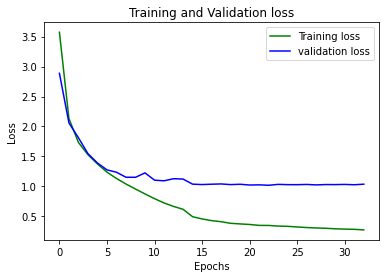

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(1,35)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

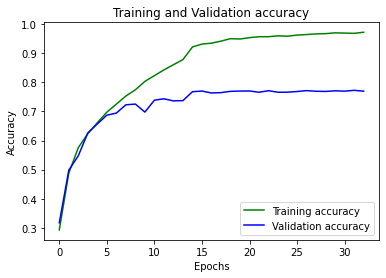

In [ ]:
train = history.history['accuracy']
val = history.history['val_accuracy']
plt.plot(train, 'g', label='Training accuracy')
plt.plot(val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()